In [1]:
import torch
import torchvision
from torchvision import transforms

In [231]:
# Load the model
model = torch.load('./model_2.pt')
model.cuda()
model.eval()

FPN(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (

In [232]:
import numpy as np
from PIL import Image
from torchvision import transforms

In [233]:
# Get image from a given path
def get_image(image_path):
    trans = transforms.Compose([transforms.ToTensor()])
    demo = Image.open(image_path)
    height, width = demo.height, demo.width
    height += 32 - (demo.height % 32) if (demo.height % 32) > 0 else 0
    width += 32 - (demo.width % 32) if (demo.width % 32) > 0 else 0
    background_color = (0, 0, 0)
    result = Image.new(demo.mode, (width, height), background_color)
    result.paste(demo, (0, 0))
    demo_img = trans(result)
    demo_array = np.moveaxis(demo_img.numpy()*255, 0, -1)
    return result, demo_img

In [234]:
from matplotlib import pyplot as plt
import time
import cv2

In [250]:
# Apply masks from neural net
def apply_mask(image: np.array, mask: torch.tensor, p=0.5):
    sh = mask.shape
    img_ = np.array(image)    
    x = np.array([255, 255, 255])
    img_[mask.cpu() > p] = x
    result_image = Image.fromarray(img_)
    return np.array(result_image)

In [251]:
# Get coordinate of the center, std in x and y
def get_stats(image: np.array):
    x_masked = []
    y_masked = []
    image = Image.fromarray(image)
    for x in range(image.width):
            for y in range(image.height):
                if image.getpixel((x,y)) != (255, 255, 255):
                    x_masked.append(x)
                    y_masked.append(y)
    return [int(np.mean(x_masked)), int(np.mean(y_masked))], np.std(x_masked), np.std(y_masked)

In [274]:
# Get coordinate of the center, widht and height
def get_center_width_height(image: np.array):
    x_filtered = []
    y_filtered = []
    image = Image.fromarray(image)
    for x in range(image.width):
            for y in range(image.height):    
                if image.getpixel((x,y)) != (255, 255, 255):
                    x_filtered.append(x)
                    y_filtered.append(y)
    mean_coord_filtered = (int(np.mean(x_filtered)), int(np.mean(y_filtered)))
    width = np.max(x_filtered) - np.min(x_filtered)
    height = np.max(y_filtered) - np.min(y_filtered)
    return mean_coord_filtered, width, height

In [275]:
def get_load_area(image: np.array, demo_img: np.array):
    arr = np.random.random((64, 64, 3))
    t = transforms.ToTensor()(arr)
    t = t[None, :].cuda().float()

    x = time.time()
    demo_img = demo_img[None, :].cuda()
    p = model.predict(demo_img)
    
    image = apply_mask(image, p[0][0])
    image = apply_mask(image, p[0][2])
    image = apply_mask(image, p[0][4])

    mean_coord, x_std, y_std = get_stats(image)
   
    x_crop = int(2 * x_std)
    y_crop = int(y_std)
    
    x = np.array([255, 255, 255])
    image[mean_coord[1] + y_crop:] = x
    if mean_coord[1] - y_crop >= 1:
        image[:mean_coord[1] - y_crop] = x
    if mean_coord[0] - 2*x_std >= 1:
        image[:, :mean_coord[0] - x_crop] = x 

    center, width, height = get_center_width_height(image)
    
    image = cv2.circle(image, mean_coord, 10, (255, 0, 0), 10)
    image = cv2.ellipse(image, mean_coord, (int(width / 2), int(height / 2)),
               0, 0, 360, (255, 0, 0), 10)
    
    image = Image.fromarray(image)
    
    mean_coord[0] = mean_coord[0] / image.width
    mean_coord[1] = mean_coord[1] / image.height
    
    width  = width / image.width
    height = height / image.height
    
    return image, mean_coord, width, height

In [276]:
from os.path import exists

In [277]:
def save_dimensions(package_id, center, width, height, path):
    if not exists(path):
        f = open(path, "a")
        f.write("package_id,board_point_x,board_point_y,width,height\n")
        f.close()

    f = open(path, "a")    
    f.write(package_id + ', ' + str(round(center[0], 6)) + ',' + str(round(center[1], 6)) + ',' + str(round(width, 6)) + ',' + str(round(height, 6)) + "\n")

In [309]:
image, demo_img = get_image('/root/test_data/20220724_143417_step_40/package_6320/color_frame.png')
im, center, width, height = get_load_area(image, demo_img)

In [310]:
save_dimensions('20220719_183951/package_3060/', center, width, height, '/root/solution/solution.txt')

In [289]:
import os
paths = []
for folder in os.listdir('test_data'):
    for packet in os.listdir(f"test_data/{folder}"):
        paths.append(f"test_data/{folder}/{packet}/color_frame.png")

In [290]:
print(len(paths), paths[0])

609 test_data/20210929_092132_step_20/package_860/color_frame.png


In [291]:
import re
for path in paths:
    image, demo_img = get_image(path)
    im, center, width, height = get_load_area(image, demo_img)
    text = re.findall(r"/(\S+/\S+/)", path)[0]
    save_dimensions(text, center, width, height, '/root/pip_install_HSE_solution.txt')

KeyboardInterrupt: 

In [ ]:
def apply_dimensions(image, center_, width_, height_):
    image_width = image.width 
    image_height = image.height
    image = np.array(image)
    center_[0] = int(center_[0] * image_width)
    center_[1] = int(center_[1] * image_height)
    image = cv2.circle(image, center_, 10, (255, 0, 0), 10)
    image = cv2.ellipse(image, center_, (int((width_ * image_width) / 2), int((height_ * image_height) / 2)),
               0, 0, 360, (255, 0, 0), 10)
    return Image.fromarray(image)

In [311]:
# center
masked_image = apply_dimensions(image, center, width, height)

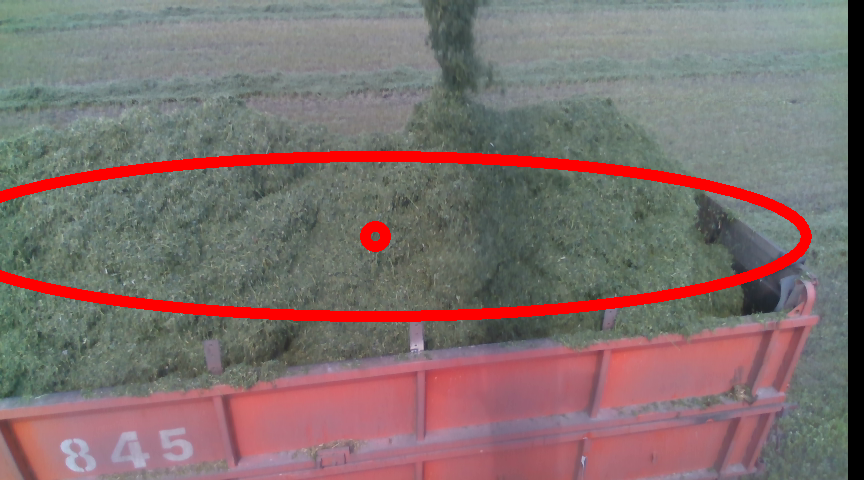

In [312]:
masked_image